In [1]:
!nvidia-smi --query-gpu=name,memory.total --format=csv,noheader
import torch
print(f"\nPyTorch: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"VRAM: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")

Tesla T4, 15360 MiB

PyTorch: 2.10.0+cu128
CUDA available: True
GPU: Tesla T4
VRAM: 15.6 GB


In [2]:
# Install GROMACS via conda (GPU-enabled)
!pip install -q condacolab
import condacolab
condacolab.install()

# After kernel restart, run this cell
!conda install -c conda-forge gromacs -y
!conda install -c conda-forge matplotlib numpy biopython nglview -y

# Verify GROMACS installation
!gmx --version | head -20
print("\n✓ GROMACS installed")

⏬ Downloading https://github.com/jaimergp/miniforge/releases/download/24.11.2-1_colab/Miniforge3-colab-24.11.2-1_colab-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:08
🔁 Restarting kernel...
Channels:
 - conda-forge
Platform: linux-64
Solving environment: / - \ done

## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - gromacs


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2026.2.25  |       hbd8a1cb_0         144 KB  conda-forge
    certifi-2026.2.25          |     pyhd8ed1ab_0         148 KB  conda-forge
    conda-24.11.3              |  py311h38be061_0         1.1 MB  conda-forge
    fftw-3.3.10                |nompi_hf1063bd_110         2.0 MB  conda-forge
    gromacs-2026.0             |nompi_h26635d9_101        33.4 MB  conda-forge
    icu-78.2                   |  

In [ ]:
##to upload direct pdb or gro files


from google.colab import files
import os

print("=" * 60)
print("UPLOAD YOUR PROTEIN STRUCTURE FILE")
print("=" * 60)
print("\nSupported formats:")
print("  • PDB (.pdb) - from RCSB PDB, AlphaFold, or other tools")
print("  • GRO (.gro) - GROMACS format")
print("\nIf you have a FASTA file, first predict structure with")
print("ColabFold or Boltz-2, then use the output PDB here.")
print("\nClick 'Choose Files' below...\n")

uploaded = files.upload()
input_file = list(uploaded.keys())[0]
file_ext = os.path.splitext(input_file)[1].lower()

print(f"\n✓ File uploaded: {input_file}")
print(f"  Size: {os.path.getsize(input_file) / 1024:.1f} KB")


In [2]:
import urllib.request
import os

pdb_id = "1AKI"
url = f"https://files.rcsb.org/download/{pdb_id}.pdb"
input_file = f"{pdb_id}.pdb"
urllib.request.urlretrieve(url, input_file)
print(f"✓ Downloaded {pdb_id}.pdb from RCSB PDB")
print(f"  Size: {os.path.getsize(input_file) / 1024:.1f} KB")

✓ Downloaded 1AKI.pdb from RCSB PDB
  Size: 113.7 KB


In [3]:
import os

work_dir = "gromacs_simulation"
os.makedirs(work_dir, exist_ok=True)

# Copy input
!cp "{input_file}" {work_dir}/protein.pdb

os.chdir(work_dir)

# Remove water and heteroatoms from crystal structure
!grep -v "HOH" protein.pdb > protein_clean.pdb

print("=" * 60)
print("STEP 1: GENERATE TOPOLOGY")
print("=" * 60)

# Generate topology using AMBER99SB-ILDN force field, TIP3P water
!echo "1" | gmx pdb2gmx -f protein_clean.pdb -o protein_processed.gro \
    -water tip3p -ff amber99sb-ildn 2>&1 | tail -10

print("\n✓ Topology generated")
print("  Force field: AMBER99SB-ILDN")
print("  Water model: TIP3P")



STEP 1: GENERATE TOPOLOGY

Writing coordinate file...

		--------- PLEASE NOTE ------------

You have successfully generated a topology from: protein_clean.pdb.

The Amber99sb-ildn force field and the tip3p water model are used.

		--------- ETON ESAELP ------------

✓ Topology generated
  Force field: AMBER99SB-ILDN
  Water model: TIP3P


In [4]:
print("=" * 60)
print("STEP 2: DEFINE SIMULATION BOX")
print("=" * 60)

# Create dodecahedral box with 1.0 nm buffer
!gmx editconf -f protein_processed.gro -o protein_box.gro \
    -c -d 1.0 -bt dodecahedron 2>&1 | tail -5

print("\n✓ Box defined (dodecahedron, 1.0 nm buffer)")

print("\n" + "=" * 60)
print("STEP 3: SOLVATE")
print("=" * 60)

# Add water
!gmx solvate -cp protein_box.gro -cs spc216.gro \
    -o protein_solvated.gro -p topol.top 2>&1 | tail -5

print("\n✓ System solvated with TIP3P water")

STEP 2: DEFINE SIMULATION BOX
    shift       :  2.477  2.770  2.461 (nm)
new center      :  5.258  5.258  2.478 (nm)
new box vectors :  7.010  7.010  7.010 (nm)
new box angles  :  60.00  60.00  90.00 (degrees)
new box volume  : 243.59               (nm^3)

✓ Box defined (dodecahedron, 1.0 nm buffer)

STEP 3: SOLVATE
Back Off! I just backed up topol.top to ./#topol.top.1#

GROMACS reminds you: "The researcher's art is first of all to find himself a good boss." (Andre Lwoff)

Adding line for 7339 solvent molecules with resname (SOL) to topology file (topol.top)

✓ System solvated with TIP3P water


In [5]:
print("=" * 60)
print("STEP 4: ADD IONS")
print("=" * 60)

# Create ions.mdp
with open("ions.mdp", "w") as f:
    f.write("""; ions.mdp - for ion addition
integrator  = steep
emtol       = 1000.0
emstep      = 0.01
nsteps      = 50000
nstlist     = 1
cutoff-scheme = Verlet
ns_type     = grid
coulombtype = PME
rcoulomb    = 1.0
rvdw        = 1.0
pbc         = xyz
""")

!gmx grompp -f ions.mdp -c protein_solvated.gro -p topol.top \
    -o ions.tpr -maxwarn 1 2>&1 | tail -3

# Add Na+ and Cl- to neutralize (group 13 = SOL)
!echo "SOL" | gmx genion -s ions.tpr -o protein_ions.gro \
    -p topol.top -pname NA -nname CL -neutral 2>&1 | tail -5

print("\n✓ System neutralized with Na+/Cl- ions")


STEP 4: ADD IONS
Estimate for the relative computational load of the PME mesh part: 0.28

This run will generate roughly 2 Mb of data
Select a continuous group of solvent molecules
Selected 13: 'SOL'

Processing topology
Replacing 8 solute molecules in topology file (topol.top)  by 0 NA and 8 CL ions.

✓ System neutralized with Na+/Cl- ions


In [6]:
print("=" * 60)
print("STEP 5: ENERGY MINIMIZATION")
print("=" * 60)

with open("em.mdp", "w") as f:
    f.write("""; em.mdp - Energy Minimization
integrator  = steep
emtol       = 1000.0
emstep      = 0.01
nsteps      = 50000
nstlist     = 1
cutoff-scheme = Verlet
ns_type     = grid
coulombtype = PME
rcoulomb    = 1.0
rvdw        = 1.0
pbc         = xyz
""")

!gmx grompp -f em.mdp -c protein_ions.gro -p topol.top -o em.tpr 2>&1 | tail -3

import time
start_em = time.time()
!gmx mdrun -v -deffnm em 2>&1 | tail -10
em_time = time.time() - start_em

print(f"\n✓ Energy minimization complete ({em_time:.0f} seconds)")

# Extract energy
!echo "10 0" | gmx energy -f em.edr -o em_potential.xvg 2>&1 | tail -5
print("✓ Potential energy extracted")


STEP 5: ENERGY MINIMIZATION
Estimate for the relative computational load of the PME mesh part: 0.28

This run will generate roughly 2 Mb of data

writing lowest energy coordinates.

Steepest Descents converged to Fmax < 1000 in 557 steps
Potential Energy  = -3.6304703e+05
Maximum force     =  9.1184955e+02 on atom 1958
Norm of force     =  2.8299671e+01

GROMACS reminds you: "I think it would be a good idea." (Mahatma Gandhi, when asked what he thought of Western civilization)


✓ Energy minimization complete (47 seconds)
All statistics are over 441 points (frames)

Energy                      Average   Err.Est.       RMSD  Tot-Drift
-------------------------------------------------------------------------------
Potential                   -347128       8100    21113.2   -53104.4  (kJ/mol)
✓ Potential energy extracted


In [7]:
print("=" * 60)
print("STEP 6: NVT EQUILIBRATION (100 ps)")
print("=" * 60)

with open("nvt.mdp", "w") as f:
    f.write("""; nvt.mdp - NVT equilibration
integrator  = md
nsteps      = 50000     ; 100 ps
dt          = 0.002
nstxout     = 500
nstvout     = 500
nstenergy   = 500
nstlog      = 500
continuation = no
constraint_algorithm = lincs
constraints = h-bonds
lincs_iter  = 1
lincs_order = 4
cutoff-scheme = Verlet
ns_type     = grid
nstlist     = 10
rcoulomb    = 1.0
rvdw        = 1.0
coulombtype = PME
pme_order   = 4
fourierspacing = 0.16
tcoupl      = V-rescale
tc-grps     = Protein Non-Protein
tau_t       = 0.1     0.1
ref_t       = 300     300
pcoupl      = no
pbc         = xyz
DispCorr    = EnerPres
gen_vel     = yes
gen_temp    = 300
gen_seed    = -1
""")

!gmx grompp -f nvt.mdp -c em.gro -r em.gro -p topol.top -o nvt.tpr 2>&1 | tail -3

start_nvt = time.time()
!gmx mdrun -deffnm nvt 2>&1 | tail -5
nvt_time = time.time() - start_nvt

print(f"\n✓ NVT equilibration complete ({nvt_time/60:.1f} minutes)")

STEP 6: NVT EQUILIBRATION (100 ps)
Estimate for the relative computational load of the PME mesh part: 0.23

This run will generate roughly 58 Mb of data
                 (ns/day)    (hour/ns)    (ms/step)  (Matom*steps/s) 
Performance:        7.007        3.425       24.661            0.972 

GROMACS reminds you: "But in my opinion, all things in nature occur mathematically." (Rene Decartes)


✓ NVT equilibration complete (20.6 minutes)


In [8]:
print("=" * 60)
print("STEP 7: NPT EQUILIBRATION (100 ps)")
print("=" * 60)

with open("npt.mdp", "w") as f:
    f.write("""; npt.mdp - NPT equilibration
integrator  = md
nsteps      = 50000     ; 100 ps
dt          = 0.002
nstxout     = 500
nstvout     = 500
nstenergy   = 500
nstlog      = 500
continuation = yes
constraint_algorithm = lincs
constraints = h-bonds
lincs_iter  = 1
lincs_order = 4
cutoff-scheme = Verlet
ns_type     = grid
nstlist     = 10
rcoulomb    = 1.0
rvdw        = 1.0
coulombtype = PME
pme_order   = 4
fourierspacing = 0.16
tcoupl      = V-rescale
tc-grps     = Protein Non-Protein
tau_t       = 0.1     0.1
ref_t       = 300     300
pcoupl      = Parrinello-Rahman
pcoupltype  = isotropic
tau_p       = 2.0
ref_p       = 1.0
compressibility = 4.5e-5
refcoord_scaling = com
pbc         = xyz
DispCorr    = EnerPres
gen_vel     = no
""")

!gmx grompp -f npt.mdp -c nvt.gro -r nvt.gro -t nvt.cpt \
    -p topol.top -o npt.tpr 2>&1 | tail -3

start_npt = time.time()
!gmx mdrun -deffnm npt 2>&1 | tail -5
npt_time = time.time() - start_npt

print(f"\n✓ NPT equilibration complete ({npt_time/60:.1f} minutes)")


STEP 7: NPT EQUILIBRATION (100 ps)
Estimate for the relative computational load of the PME mesh part: 0.23

This run will generate roughly 58 Mb of data
                 (ns/day)    (hour/ns)    (ms/step)  (Matom*steps/s) 
Performance:        7.344        3.268       23.531            1.018 

GROMACS reminds you: "Don't be afraid of hard work. Nothing worthwhile comes easily. Don't let others discourage you or tell you that you can't do it. In my day I was told women didn't go into chemistry. I saw no reason why we couldn't." (Gertrude Elion)


✓ NPT equilibration complete (19.6 minutes)


In [9]:
print("=" * 60)
print("STEP 8: PRODUCTION MD (500 ps demo)")
print("=" * 60)
print("⚠️  Real simulations use 10-1000 ns; this is a short demo")

with open("md.mdp", "w") as f:
    f.write("""; md.mdp - Production MD
integrator  = md
nsteps      = 250000    ; 500 ps
dt          = 0.002
nstxout     = 5000
nstvout     = 5000
nstenergy   = 5000
nstlog      = 5000
nstxout-compressed = 5000
compressed-x-grps  = System
continuation = yes
constraint_algorithm = lincs
constraints = h-bonds
lincs_iter  = 1
lincs_order = 4
cutoff-scheme = Verlet
ns_type     = grid
nstlist     = 10
rcoulomb    = 1.0
rvdw        = 1.0
coulombtype = PME
pme_order   = 4
fourierspacing = 0.16
tcoupl      = V-rescale
tc-grps     = Protein Non-Protein
tau_t       = 0.1     0.1
ref_t       = 300     300
pcoupl      = Parrinello-Rahman
pcoupltype  = isotropic
tau_p       = 2.0
ref_p       = 1.0
compressibility = 4.5e-5
pbc         = xyz
DispCorr    = EnerPres
gen_vel     = no
""")

!gmx grompp -f md.mdp -c npt.gro -t npt.cpt -p topol.top -o md.tpr 2>&1 | tail -3

start_md = time.time()
!gmx mdrun -deffnm md 2>&1 | tail -10
md_time = time.time() - start_md

print(f"\n✓ Production MD complete ({md_time/60:.1f} minutes)")

STEP 8: PRODUCTION MD (500 ps demo)
⚠️  Real simulations use 10-1000 ns; this is a short demo
Estimate for the relative computational load of the PME mesh part: 0.22

This run will generate roughly 36 Mb of data
Writing final coordinates.

               Core t (s)   Wall t (s)        (%)
       Time:    12012.746     6006.373      200.0
                         1h40:06
                 (ns/day)    (hour/ns)    (ms/step)  (Matom*steps/s) 
Performance:        7.192        3.337       24.025            0.997 

GROMACS reminds you: "Got Coffee, Got Donuts, Got Wasted" (F. Black)


✓ Production MD complete (100.1 minutes)


ANALYSIS

Selected 4: 'Backbone'
Selected 4: 'Backbone'

GROMACS reminds you: "There is no such thing as free energy. Anyone who advocates it does not know what he is talking about." (Alireza Haghighat)

Energy                      Average   Err.Est.       RMSD  Tot-Drift
-------------------------------------------------------------------------------
Kinetic En.                   61045         18    423.981   -19.0385  (kJ/mol)


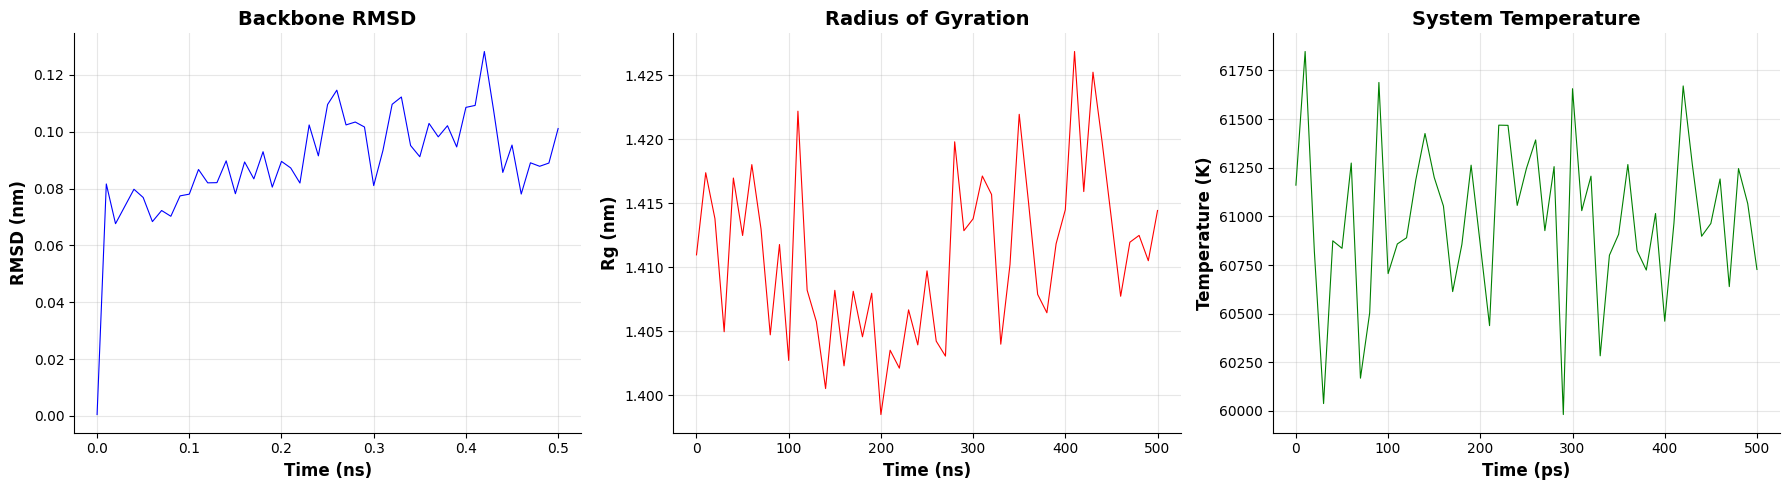

✓ Analysis plots saved


In [10]:
import matplotlib.pyplot as plt
import numpy as np

print("=" * 60)
print("ANALYSIS")
print("=" * 60)

# RMSD
!echo "4 4" | gmx rms -s md.tpr -f md.xtc -o rmsd.xvg -tu ns 2>&1 | tail -3

# Radius of Gyration
!echo "1" | gmx gyrate -s md.tpr -f md.xtc -o gyrate.xvg 2>&1 | tail -3

# Energy
!echo "12 0" | gmx energy -f md.edr -o temperature.xvg 2>&1 | tail -3

# Parse and plot
def parse_xvg(filename):
    x, y = [], []
    with open(filename, 'r') as f:
        for line in f:
            if line.startswith(('#', '@')):
                continue
            parts = line.split()
            if len(parts) >= 2:
                x.append(float(parts[0]))
                y.append(float(parts[1]))
    return np.array(x), np.array(y)

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# RMSD plot
try:
    x, y = parse_xvg("rmsd.xvg")
    axes[0].plot(x, y, 'b-', linewidth=0.8)
    axes[0].set_xlabel("Time (ns)", fontsize=12, fontweight='bold')
    axes[0].set_ylabel("RMSD (nm)", fontsize=12, fontweight='bold')
    axes[0].set_title("Backbone RMSD", fontsize=14, fontweight='bold')
    axes[0].grid(True, alpha=0.3)
except:
    axes[0].text(0.5, 0.5, "RMSD data not available", transform=axes[0].transAxes, ha='center')

# Radius of Gyration
try:
    x, y = parse_xvg("gyrate.xvg")
    axes[1].plot(x, y, 'r-', linewidth=0.8)
    axes[1].set_xlabel("Time (ns)", fontsize=12, fontweight='bold')
    axes[1].set_ylabel("Rg (nm)", fontsize=12, fontweight='bold')
    axes[1].set_title("Radius of Gyration", fontsize=14, fontweight='bold')
    axes[1].grid(True, alpha=0.3)
except:
    axes[1].text(0.5, 0.5, "Rg data not available", transform=axes[1].transAxes, ha='center')

# Temperature
try:
    x, y = parse_xvg("temperature.xvg")
    axes[2].plot(x, y, 'g-', linewidth=0.8)
    axes[2].set_xlabel("Time (ps)", fontsize=12, fontweight='bold')
    axes[2].set_ylabel("Temperature (K)", fontsize=12, fontweight='bold')
    axes[2].set_title("System Temperature", fontsize=14, fontweight='bold')
    axes[2].grid(True, alpha=0.3)
except:
    axes[2].text(0.5, 0.5, "Temp data not available", transform=axes[2].transAxes, ha='center')

for ax in axes:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.savefig("md_analysis.png", dpi=300, bbox_inches='tight')
plt.show()
print("✓ Analysis plots saved")


In [11]:
os.chdir("..")

# Create results package
!mkdir -p gromacs_output
!cp {work_dir}/md.gro gromacs_output/
!cp {work_dir}/md.xtc gromacs_output/ 2>/dev/null
!cp {work_dir}/md.tpr gromacs_output/
!cp {work_dir}/topol.top gromacs_output/
!cp {work_dir}/*.xvg gromacs_output/
!cp {work_dir}/md_analysis.png gromacs_output/
!cp {work_dir}/*.mdp gromacs_output/

total_time = em_time + nvt_time + npt_time + md_time

with open("gromacs_output/analysis_summary.txt", "w") as f:
    f.write("=" * 70 + "\n")
    f.write("GROMACS MOLECULAR DYNAMICS SIMULATION - SUMMARY\n")
    f.write("=" * 70 + "\n\n")
    f.write(f"Input: {input_file}\n")
    f.write(f"Force field: AMBER99SB-ILDN\n")
    f.write(f"Water model: TIP3P\n")
    f.write(f"Temperature: 300 K\n")
    f.write(f"Pressure: 1.0 bar\n\n")
    f.write("SIMULATION STEPS:\n")
    f.write(f"  1. Energy Minimization: {em_time:.0f}s\n")
    f.write(f"  2. NVT Equilibration (100 ps): {nvt_time/60:.1f}min\n")
    f.write(f"  3. NPT Equilibration (100 ps): {npt_time/60:.1f}min\n")
    f.write(f"  4. Production MD (500 ps): {md_time/60:.1f}min\n")
    f.write(f"  Total: {total_time/60:.1f} minutes\n")

!zip -r -q gromacs_results.zip gromacs_output/
print("Package size:")
!ls -lh gromacs_results.zip

from google.colab import files
files.download('gromacs_results.zip')
print("\n✓ Done! Move to stowers-gpu-tools/gromacs/results/sample_output/")


Package size:
-rw-r--r-- 1 root root 5.8M Feb 25 19:59 gromacs_results.zip


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


✓ Done! Move to stowers-gpu-tools/gromacs/results/sample_output/
